# * Preprocessing*

### * make the dataset. Featureset containing AND Target variable column( Difference_score/class)*

In [1]:
# raw featureset
import pandas as pd
df = pd.read_csv(r'C:\Users\u1246538\Downloads\liss-data\Notebooks_MHI-5\selected_features_rf_with_id.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   nomem_encr                             995 non-null    int64  
 1   emotional_stability                    995 non-null    float64
 2   self_esteem                            994 non-null    float64
 3   Self-Rated_Health                      995 non-null    int64  
 4   age                                    995 non-null    float64
 5   Health_Hindrance_to_Daily_Functioning  993 non-null    float64
 6   nomem_encr.1                           995 non-null    int64  
 7   Sleeping_Problems                      993 non-null    float64
 8   conscientiousness                      995 non-null    float64
 9   composite_values                       994 non-null    float64
 10  intellect_imagination                  995 non-null    float64
dtypes: flo

In [3]:
# Merge featureset + target variable(difference_score)
import pandas as pd

data_1_subset = pd.read_csv('merged_difference_subset.csv')
data_1_subset.info()


# Step 2: Merge on 'nomem_encr'
df_merged = df.merge(data_1_subset, on='nomem_encr', how='left')

#drop entries with NAN
df_final = df_merged.dropna().copy() # this deletes all nan entries To check--print(df_final.isna().sum())


df_final.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   difference_mhi5  895 non-null    float64
 1   change_class     895 non-null    float64
 2   nomem_encr       995 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 23.4 KB
<class 'pandas.core.frame.DataFrame'>
Index: 894 entries, 0 to 993
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   nomem_encr                             894 non-null    int64  
 1   emotional_stability                    894 non-null    float64
 2   self_esteem                            894 non-null    float64
 3   Self-Rated_Health                      894 non-null    int64  
 4   age                                    894 non-null    float64
 5   Health_Hindrance_to_Daily_Function

33% grens: -4.00, 66% grens: 4.00


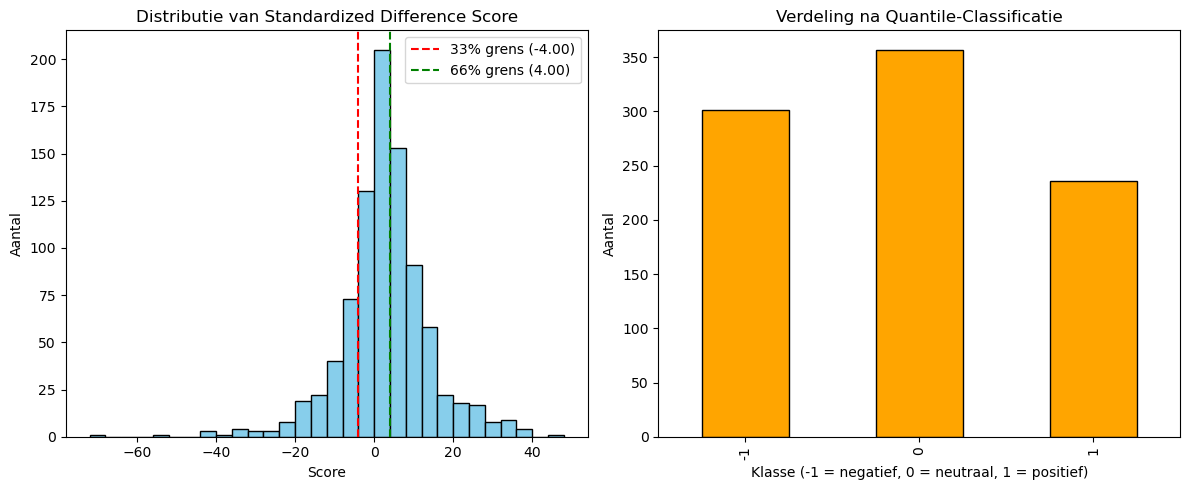

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Bepaal quantile-grenzen op schone data
q1, q2 = np.quantile(df_final['difference_mhi5'], [0.33, 0.66])
print(f"33% grens: {q1:.2f}, 66% grens: {q2:.2f}")

# Classificeer scores
def assign_class(score, q1, q2):
    if score <= q1:
        return -1
    elif score <= q2:
        return 0
    else:
        return 1

df_final['diff_class'] = df_final['difference_mhi5'].apply(lambda x: assign_class(x, q1, q2))

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_final['difference_mhi5'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(q1, color='red', linestyle='--', label=f'33% grens ({q1:.2f})')
plt.axvline(q2, color='green', linestyle='--', label=f'66% grens ({q2:.2f})')
plt.title('Distributie van Standardized Difference Score')
plt.xlabel('Score')
plt.ylabel('Aantal')
plt.legend()

plt.subplot(1, 2, 2)
df_final['diff_class'].value_counts().sort_index().plot(kind='bar', color='orange', edgecolor='black')
plt.title('Verdeling na Quantile-Classificatie')
plt.xlabel('Klasse (-1 = negatief, 0 = neutraal, 1 = positief)')
plt.ylabel('Aantal')

plt.tight_layout()
plt.show()


In [14]:

#Now split into X and y
X = df_final.drop(columns=['difference_mhi5', 'diff_class', 'change_class' , 'nomem_encr']) # also drop ID column and "chnage_class'in previous preprocessing i made this,but do not use it anymore
y = df_final['diff_class']

# (Optional) Check
print(X.shape, y.shape)
X.info()



(894, 10) (894,)
<class 'pandas.core.frame.DataFrame'>
Index: 894 entries, 0 to 993
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   emotional_stability                    894 non-null    float64
 1   self_esteem                            894 non-null    float64
 2   Self-Rated_Health                      894 non-null    int64  
 3   age                                    894 non-null    float64
 4   Health_Hindrance_to_Daily_Functioning  894 non-null    float64
 5   nomem_encr.1                           894 non-null    int64  
 6   Sleeping_Problems                      894 non-null    float64
 7   conscientiousness                      894 non-null    float64
 8   composite_values                       894 non-null    float64
 9   intellect_imagination                  894 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 76.8 KB


### ***Split data***


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Step 1: Split
X_train, X_test, y_train_raw, y_test_raw = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Step 2: Encode
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)

# Optional: Save encoder
import joblib
joblib.dump(le, 'label_encoder_diff6_class.pkl')


['label_encoder_diff6_class.pkl']

## ** Modelling: Training the 4 machine learning models**

### *** logistic regression

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import joblib

# Sampler dictionary
samplers = {
    'none': None,
    'undersample': RandomUnderSampler(random_state=42),
    'smotetomek': SMOTETomek(random_state=42)
}

# Hyperparameter grid
param_grid_lr = {
    'sampler': [samplers['none'], samplers['undersample'], samplers['smotetomek']],
    'classifier__C': [0.01, 0.1, 1, 10]
}

# Pipeline
pipeline_lr = ImbPipeline([
    ('sampler', SMOTETomek()),  # wordt geswitched op basis van de param_grid_lr
    ('scaler', StandardScaler()), # hier doen na datasplit anders dataleakage niet bij preprocessing.
    ('classifier', LogisticRegression(max_iter=1000, multi_class= 'multinomial', solver= 'lbfgs', random_state=42))
    # multinomial for true multiclass, lbfgs handles it well
])

# GridSearch
grid_lr = GridSearchCV(pipeline_lr, param_grid=param_grid_lr, cv=3, scoring='f1_macro', n_jobs=-1) # f1_macro for multicalss, cv gaat automatisch stratifiedsplit. hier zetten ze in plats van 3 ook inner_cv

# nested cross_validation
from sklearn.model_selection import cross_validate
nested_cv_search = cross_validate(
    grid_lr,
    X=X_train,
    y=y_train,
    cv=5, #hier kunnen ze ook outer_cv zetten ipv 5 
    scoring='f1_macro',
    error_score='raise',
    return_estimator=True,
    return_train_score=False,
    verbose=1,
    n_jobs=-1
)
print("Nested CV results:")
print(nested_cv_search['test_score'])
print("Mean F1_macro score:", nested_cv_search['test_score'].mean())
print('STD F1_macro score:', nested_cv_search['test_score'].std())
best_score_index = np.argmax(nested_cv_search['test_score'])
best_model = nested_cv_search['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)
# print the parameters of all 5 models
for i, model in enumerate(nested_cv_search['estimator']):
    print(f"Model {i+1} parameters: {model.best_params_}")

# sla de nested_cv op
joblib.dump(nested_cv_search, 'nested_cv_search_lr_diff_RFImportance.pkl')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Nested CV results:
[0.39000278 0.43279243 0.37866099 0.41210483 0.43929605]
Mean F1_macro score: 0.4105714166901896
STD F1_macro score: 0.023505629108152695
Parameters of the best model: {'classifier__C': 10, 'sampler': SMOTETomek(random_state=42)}
Model 1 parameters: {'classifier__C': 0.1, 'sampler': RandomUnderSampler(random_state=42)}
Model 2 parameters: {'classifier__C': 0.01, 'sampler': SMOTETomek(random_state=42)}
Model 3 parameters: {'classifier__C': 0.01, 'sampler': RandomUnderSampler(random_state=42)}
Model 4 parameters: {'classifier__C': 0.01, 'sampler': RandomUnderSampler(random_state=42)}
Model 5 parameters: {'classifier__C': 10, 'sampler': SMOTETomek(random_state=42)}


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished


['nested_cv_search_lr_diff_RFImportance.pkl']

### *** random Forest***

In [24]:
import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, CategoricalDistribution
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold, cross_validate
import numpy as np
import joblib

# Set Optuna logging to warning only
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Optuna study
optuna_study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Sampler dictionary
samplers = {
    'none': 'passthrough',
    'undersample': RandomUnderSampler(random_state=42),
    'smotetomek': SMOTETomek(random_state=42)
}

sampler_map = {
    'none': 'passthrough',
    'undersample': samplers['undersample'],
    'smotetomek': samplers['smotetomek']
}

# Custom pipeline class to resolve sampler names
class SamplerResolvingPipeline(ImbPipeline):
    def set_params(self, **kwargs):
        if 'sampler' in kwargs and isinstance(kwargs['sampler'], str):
            kwargs['sampler'] = sampler_map[kwargs['sampler']]
        return super().set_params(**kwargs)

# Define pipeline
pipeline_rf = SamplerResolvingPipeline([
    ('sampler', 'passthrough'),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Define search space
param_distributions_rf = {
    'sampler': CategoricalDistribution(['none', 'undersample', 'smotetomek']),
    'classifier__n_estimators': IntDistribution(50, 250, step=50),
    'classifier__max_depth': CategoricalDistribution([None, 5, 10, 15, 20]),
    'classifier__max_features': CategoricalDistribution(['sqrt', 'log2']),
    'classifier__min_samples_split': IntDistribution(2, 10),
    'classifier__min_samples_leaf': IntDistribution(1, 4)
}

# OptunaSearchCV setup for multiclass
optuna_search_rf = OptunaSearchCV(
    estimator=pipeline_rf,
    param_distributions=param_distributions_rf,
    cv=3,
    n_trials=50,
    study=optuna_study,
    scoring='f1_macro',  # <<< Use macro F1 for multiclass
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Nested CV
nested_cv_search = cross_validate(
    optuna_search_rf,
    X=X_train,  
    y=y_train,  # replace with your multiclass `difference_score` target
    cv=5,
    scoring='f1_macro',  # f1_macro for multi class 
    error_score='raise',
    return_estimator=True,
    return_train_score=False,
    verbose=1,
    n_jobs=-1
)

# Results
print("Nested CV results:")
print(nested_cv_search['test_score'])
print("Mean F1_macro score:", nested_cv_search['test_score'].mean())
print("STD F1_macro score:", nested_cv_search['test_score'].std())

# Best model
best_score_index = np.argmax(nested_cv_search['test_score'])
best_model = nested_cv_search['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

# All model parameters
for i, model in enumerate(nested_cv_search['estimator']):
    print(f"Model {i+1} parameters: {model.best_params_}")

# Save
joblib.dump(nested_cv_search, 'nested_cv_search_rf_diff_RFImportance.pkl')


C:\Users\u1246538\AppData\Local\Temp\ipykernel_18852\2893722950.py:60: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search_rf = OptunaSearchCV(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
C:\Users\u1246538\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:125: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  new_object = klass(**new_object_params)


Nested CV results:
[0.41122086 0.40524905 0.37133522 0.42653673 0.4071666 ]
Mean F1_macro score: 0.40430169189573373
STD F1_macro score: 0.018100636157362217
Parameters of the best model: {'sampler': 'smotetomek', 'classifier__n_estimators': 50, 'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 3}
Model 1 parameters: {'sampler': 'none', 'classifier__n_estimators': 250, 'classifier__max_depth': None, 'classifier__max_features': 'log2', 'classifier__min_samples_split': 3, 'classifier__min_samples_leaf': 2}
Model 2 parameters: {'sampler': 'smotetomek', 'classifier__n_estimators': 50, 'classifier__max_depth': None, 'classifier__max_features': 'log2', 'classifier__min_samples_split': 7, 'classifier__min_samples_leaf': 3}
Model 3 parameters: {'sampler': 'smotetomek', 'classifier__n_estimators': 200, 'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 10, 'classifie

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.3s finished


['nested_cv_search_rf_diff_RFImportance.pkl']

### ***SVM***

In [26]:
import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import CategoricalDistribution, FloatDistribution, IntDistribution
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import joblib

# 1. Sampler map
sampler_map = {
    'none': 'passthrough',
    'undersample': RandomUnderSampler(random_state=42),
    'smotetomek': SMOTETomek(random_state=42)
}

# 2. Custom pipeline
class SamplerResolvingPipeline(ImbPipeline):
    def set_params(self, **kwargs):
        if 'sampler' in kwargs and isinstance(kwargs['sampler'], str):
            kwargs['sampler'] = sampler_map[kwargs['sampler']]
        return super().set_params(**kwargs)

pipeline = SamplerResolvingPipeline([
    ('sampler', 'passthrough'),
    ('scaler', StandardScaler()),
    ('classifier', SVC(probability=True, random_state=42))  # OvR is default for multiclass
])

# 3. Optuna hyperparameter space
param_distributions = {
    'sampler': CategoricalDistribution(['none', 'undersample', 'smotetomek']),
    'classifier__kernel': CategoricalDistribution(['linear', 'rbf', 'poly']),
    'classifier__C': FloatDistribution(0.1, 100, log=True),
    'classifier__gamma': CategoricalDistribution(['scale', 'auto', 0.1, 0.01, 0.001]),
    'classifier__degree': IntDistribution(2, 5),
    'classifier__class_weight': CategoricalDistribution([None, 'balanced'])
}

# 4. Optuna study
optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna_study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)

# 5. OptunaSearchCV (inner 3-fold)
optuna_search = OptunaSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    cv=3,
    n_trials=50,
    study=optuna_study,
    scoring='f1_macro',  # <-- change to macro for multiclass
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 6. Outer nested CV (5-fold)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
nested_cv_results = cross_validate(
    optuna_search,
    X=X_train,
    y=y_train,  # already label-encoded [0, 1, 2]
    cv=outer_cv,
    scoring='f1_macro',  
    return_estimator=True,
    return_train_score=False,
    verbose=1,
    n_jobs=-1
)

# 7. Results
print("Nested CV F1 scores:", nested_cv_results['test_score'])
print("Mean F1 score:", np.mean(nested_cv_results['test_score']))
print("STD F1 score:", np.std(nested_cv_results['test_score']))

print("Best parameters per fold:")
for i, model in enumerate(nested_cv_results['estimator']):
    print(f"Fold {i+1}: {model.best_params_}")

best_score_index = np.argmax(nested_cv_results['test_score'])
best_model = nested_cv_results['estimator'][best_score_index]
print("Parameters of the best overall model:", best_model.best_params_)

# Save
joblib.dump(nested_cv_results, 'nested_cv_optuna_svm_diff_RFImportance.pkl')


C:\Users\u1246538\AppData\Local\Temp\ipykernel_18852\4018227650.py:51: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
C:\Users\u1246538\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:125: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  new_object = klass(**new_object_params)


Nested CV F1 scores: [0.45374733 0.35923755 0.37361185 0.4062029  0.43738063]
Mean F1 score: 0.4060360521847196
STD F1 score: 0.03605635955622734
Best parameters per fold:
Fold 1: {'sampler': 'none', 'classifier__kernel': 'rbf', 'classifier__C': 4.735161268912657, 'classifier__gamma': 0.001, 'classifier__degree': 5, 'classifier__class_weight': 'balanced'}
Fold 2: {'sampler': 'smotetomek', 'classifier__kernel': 'rbf', 'classifier__C': 62.47736797517442, 'classifier__gamma': 0.001, 'classifier__degree': 3, 'classifier__class_weight': 'balanced'}
Fold 3: {'sampler': 'none', 'classifier__kernel': 'linear', 'classifier__C': 17.81429916693037, 'classifier__gamma': 0.01, 'classifier__degree': 5, 'classifier__class_weight': 'balanced'}
Fold 4: {'sampler': 'none', 'classifier__kernel': 'rbf', 'classifier__C': 6.179463761411535, 'classifier__gamma': 0.001, 'classifier__degree': 5, 'classifier__class_weight': 'balanced'}
Fold 5: {'sampler': 'undersample', 'classifier__kernel': 'linear', 'classifi

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.4s finished


['nested_cv_optuna_svm_diff_RFImportance.pkl']

### ***XGBoost***

In [28]:
import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import CategoricalDistribution, FloatDistribution, IntDistribution
import numpy as np
import joblib
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler


# === Sampler map ===
sampler_map = {
    'none': 'passthrough',
    'undersample': RandomUnderSampler(random_state=42),
    'smotetomek': SMOTETomek(random_state=42)
}

# === Custom pipeline ===
class SamplerResolvingPipeline(ImbPipeline):
    def set_params(self, **kwargs):
        if 'sampler' in kwargs and isinstance(kwargs['sampler'], str):
            kwargs['sampler'] = sampler_map[kwargs['sampler']]
        return super().set_params(**kwargs)

# === Define pipeline ===
pipeline = SamplerResolvingPipeline([
    ('sampler', 'passthrough'),
    ('scaler', StandardScaler()),
    ('classifier', xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=3,  # 3 encoded classes: [0, 1, 2]
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42
    ))
])

# === Optuna search space ===
param_distributions = {
    'sampler': CategoricalDistribution(['none', 'undersample', 'smotetomek']),
    'classifier__n_estimators': CategoricalDistribution([50, 100, 200, 400, 500]),
    'classifier__learning_rate': FloatDistribution(0.01, 0.1, log=True),
    'classifier__max_depth': CategoricalDistribution([2, 4, 6, 10, 15]),
    'classifier__min_child_weight': CategoricalDistribution([1, 3, 5]),
    'classifier__subsample': CategoricalDistribution([0.6, 0.8, 1.0]),
    'classifier__colsample_bytree': CategoricalDistribution([0.6, 0.8, 1.0]),
    'classifier__gamma': FloatDistribution(0.0, 1.0, step=0.1),
    'classifier__reg_alpha': FloatDistribution(0.001, 5.0, log=True),
    'classifier__reg_lambda': FloatDistribution(0.001, 5.0, log=True),
}

# === Optuna study ===
optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna_study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)

# === Inner CV with OptunaSearchCV ===
optuna_search = OptunaSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    cv=3,
    n_trials=50,
    study=optuna_study,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# === Outer nested cross-validation ===
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
nested_cv_results = cross_validate(
    optuna_search,
    X=X_train,
    y=y_train,  # Already encoded!
    cv=outer_cv,
    scoring='f1_macro',
    return_estimator=True,
    return_train_score=False,
    verbose=1,
    n_jobs=-1
)

# === Print results ===
print("Nested CV F1 scores:", nested_cv_results['test_score'])
print("Mean F1 score:", np.mean(nested_cv_results['test_score']))
print("STD F1 score:", np.std(nested_cv_results['test_score']))
print("Best parameters per fold:")
for i, model in enumerate(nested_cv_results['estimator']):
    print(f"Fold {i+1}: {model.best_params_}")


# === Best model from CV ===
best_score_index = np.argmax(nested_cv_results['test_score'])
best_model = nested_cv_results['estimator'][best_score_index]
print(f"Best model (fold {best_score_index+1}) parameters:")
print(best_model.best_params_)

# === Save model and encoder ===
joblib.dump(nested_cv_results, 'nested_cv_optuna_xgb_diff_RFImportance.pkl')



C:\Users\u1246538\AppData\Local\Temp\ipykernel_18852\601607735.py:63: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
C:\Users\u1246538\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:125: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  new_object = klass(**new_object_params)
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.9s finished


Nested CV F1 scores: [0.3891195  0.31426038 0.31946104 0.44055588 0.37547778]
Mean F1 score: 0.367774915472593
STD F1 score: 0.04692553532579612
Best parameters per fold:
Fold 1: {'sampler': 'undersample', 'classifier__n_estimators': 200, 'classifier__learning_rate': 0.014785417496422702, 'classifier__max_depth': 2, 'classifier__min_child_weight': 5, 'classifier__subsample': 0.6, 'classifier__colsample_bytree': 1.0, 'classifier__gamma': 1.0, 'classifier__reg_alpha': 0.02643578801816651, 'classifier__reg_lambda': 0.2783785081042749}
Fold 2: {'sampler': 'smotetomek', 'classifier__n_estimators': 200, 'classifier__learning_rate': 0.09216056322741488, 'classifier__max_depth': 2, 'classifier__min_child_weight': 5, 'classifier__subsample': 0.8, 'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0.9, 'classifier__reg_alpha': 0.11353201500218374, 'classifier__reg_lambda': 0.16204698333997233}
Fold 3: {'sampler': 'none', 'classifier__n_estimators': 500, 'classifier__learning_rate': 0.0727

['nested_cv_optuna_xgb_diff_RFImportance.pkl']

## **Find Best Model( highest mean F1_macro) and test on Hold_out Test Set**

### More Evaluation metrics

LogisticRegression: Mean F1_macro = 0.4106, Std = 0.0235
RandomForest: Mean F1_macro = 0.4043, Std = 0.0181
SVM: Mean F1_macro = 0.4060, Std = 0.0361
XGBoost: Mean F1_macro = 0.3678, Std = 0.0469

Best model: LogisticRegression (fold 5)
Best estimator params: {'classifier__C': 10, 'sampler': SMOTETomek(random_state=42)}

=== Classification Report - LogisticRegression ===
              precision    recall  f1-score   support

          -1       0.32      0.27      0.29        60
           0       0.45      0.40      0.43        72
           1       0.34      0.47      0.39        47

    accuracy                           0.37       179
   macro avg       0.37      0.38      0.37       179
weighted avg       0.38      0.37      0.37       179



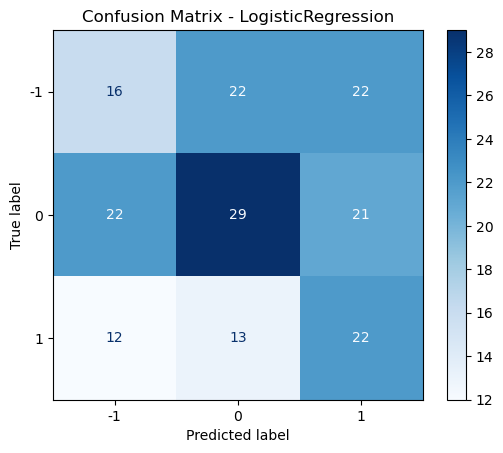

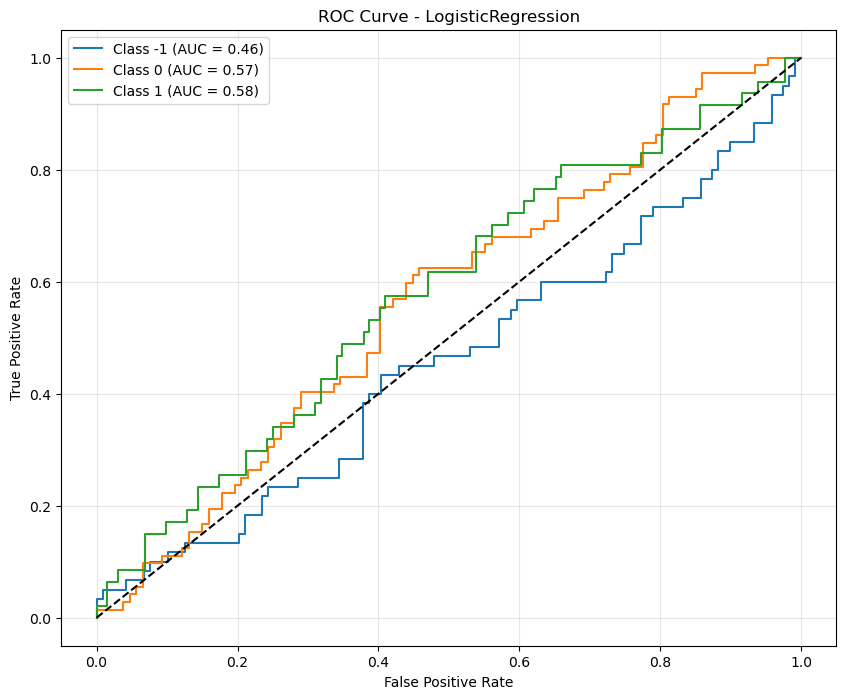

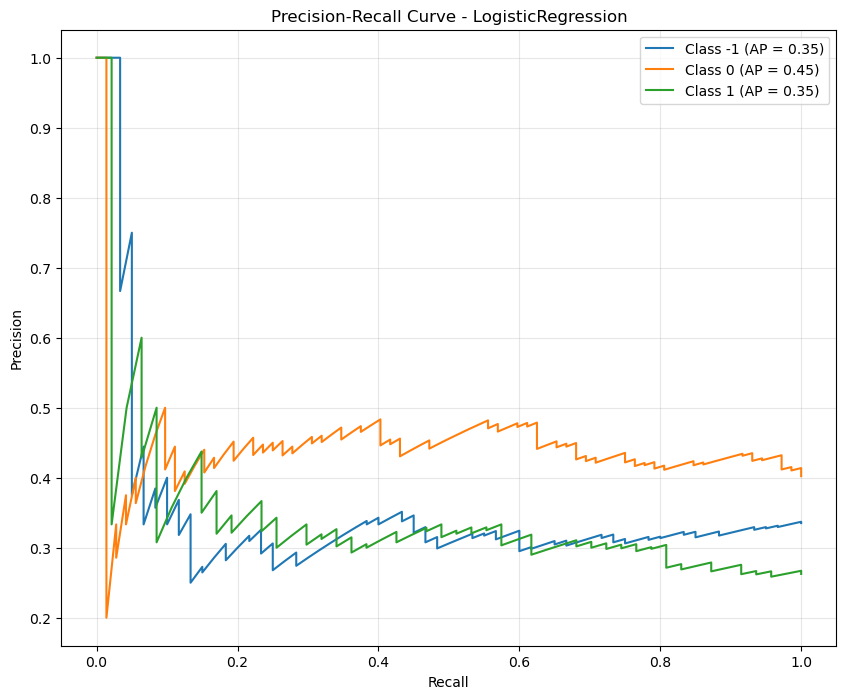

Macro AUC-ROC: 0.5336
Macro Average Precision: 0.3827

Calculating Permutation Feature Importance...


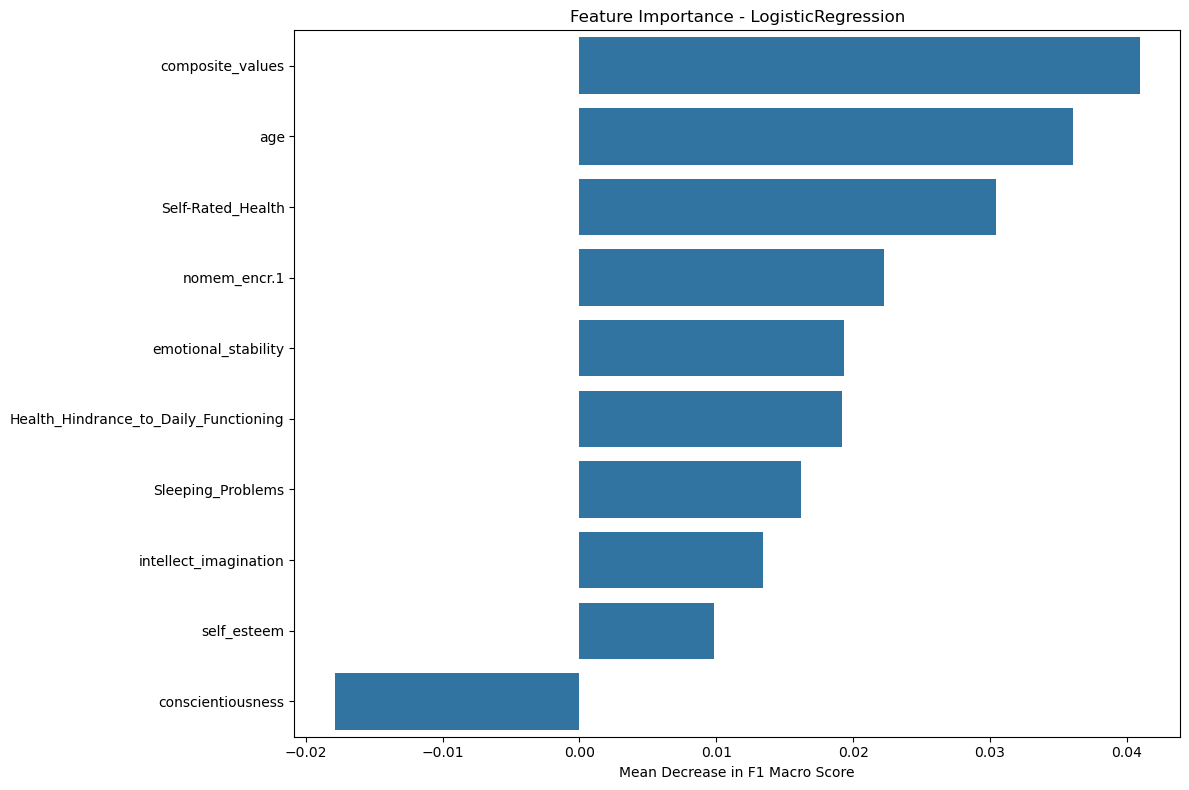


Top 10 Most Important Features:
composite_values: 0.0409
age: 0.0360
Self-Rated_Health: 0.0305
nomem_encr.1: 0.0222
emotional_stability: 0.0193
Health_Hindrance_to_Daily_Functioning: 0.0192
Sleeping_Problems: 0.0162
intellect_imagination: 0.0134
self_esteem: 0.0098
conscientiousness: -0.0179


In [30]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

# === Step 1: Load encoder and test labels ===
le = joblib.load("label_encoder_diff_class.pkl")
y_test_encoded = le.transform(y_test_raw)  # Assuming y_test_raw is the original (unencoded) labels

# === Step 2: Load models ===
models_info = {
    "LogisticRegression": joblib.load("nested_cv_search_lr_diff_RFImportance.pkl"),
    "RandomForest": joblib.load("nested_cv_search_rf_diff_RFImportance.pkl"),
    "SVM": joblib.load("nested_cv_optuna_svm_diff_RFImportance.pkl"),
    "XGBoost": joblib.load("nested_cv_optuna_xgb_diff_RFImportance.pkl"),
}

# === Step 3: Compare mean F1_macro scores ===
for name, result in models_info.items():
    mean_f1 = np.mean(result['test_score'])
    std_f1 = np.std(result['test_score'])
    print(f"{name}: Mean F1_macro = {mean_f1:.4f}, Std = {std_f1:.4f}")

# === Step 4: Select best model ===
best_model_name = max(models_info, key=lambda name: np.mean(models_info[name]['test_score']))
best_model_cv = models_info[best_model_name]
best_index = np.argmax(best_model_cv['test_score'])
best_estimator = best_model_cv['estimator'][best_index]

print(f"\nBest model: {best_model_name} (fold {best_index+1})")
print("Best estimator params:", best_estimator.best_params_)

# === Step 5: Predict and decode ===
y_pred_encoded = best_estimator.predict(X_test)
y_pred = le.inverse_transform(y_pred_encoded)  # Human-readable
y_true = le.inverse_transform(y_test_encoded)

# === Step 6: Classification Report ===
print(f"\n=== Classification Report - {best_model_name} ===")
target_names = [str(c) for c in le.classes_]
print(classification_report(y_test_encoded, y_pred_encoded, target_names=target_names))

# === Step 7: Confusion Matrix ===
cm = confusion_matrix(y_test_encoded, y_pred_encoded)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

# === Step 8: ROC & PR Curves (One-vs-Rest) ===
if hasattr(best_estimator, "predict_proba"):
    y_proba = best_estimator.predict_proba(X_test)

    fpr, tpr, roc_auc = {}, {}, {}
    precision, recall, pr_auc = {}, {}, {}
    n_classes = y_proba.shape[1]

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_encoded == i, y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        precision[i], recall[i], _ = precision_recall_curve(y_test_encoded == i, y_proba[:, i])
        pr_auc[i] = average_precision_score(y_test_encoded == i, y_proba[:, i])

    # ROC Curve
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        label = f'Class {le.inverse_transform([i])[0]} (AUC = {roc_auc[i]:.2f})'
        plt.plot(fpr[i], tpr[i], label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve - {best_model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # PR Curve
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        label = f'Class {le.inverse_transform([i])[0]} (AP = {pr_auc[i]:.2f})'
        plt.plot(recall[i], precision[i], label=label)
    plt.title(f'Precision-Recall Curve - {best_model_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"Macro AUC-ROC: {np.mean(list(roc_auc.values())):.4f}")
    print(f"Macro Average Precision: {np.mean(list(pr_auc.values())):.4f}")
else:
    print(f"Note: {best_model_name} does not support probability predictions for ROC/PR curves.")

# === Step 9: Permutation Feature Importance ===
print("\nCalculating Permutation Feature Importance...")
result = permutation_importance(
    best_estimator,
    X_test,
    y_test_encoded,
    scoring='f1_macro',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

feature_names = X_test.columns if hasattr(X_test, 'columns') else [f"Feature {i}" for i in range(X_test.shape[1])]
sorted_idx = result.importances_mean.argsort()[::-1]

plt.figure(figsize=(12, 8))
sns.barplot(
    x=result.importances_mean[sorted_idx],
    y=[feature_names[i] for i in sorted_idx]
)
plt.title(f"Feature Importance - {best_model_name}")
plt.xlabel("Mean Decrease in F1 Macro Score")
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
for i in sorted_idx[:10]:
    print(f"{feature_names[i]}: {result.importances_mean[i]:.4f}")


In [32]:
## To save all metrics in PDF

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import io

# Create PDF to collect all output
with PdfPages(f"{best_model_name}_evaluation_report_diff6.pdf") as pdf:

    # === Classification Report (Text)
    report_text = classification_report(
        y_test_encoded, y_pred_encoded, target_names=[str(c) for c in le.classes_]
    )
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.axis('off')
    ax.text(0, 1, report_text, fontsize=10, va='top', family='monospace')
    ax.set_title("Classification Report")
    pdf.savefig(fig)
    plt.close(fig)

    # === Confusion Matrix
    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(ax=ax, cmap='Blues')
    plt.title(f'Confusion Matrix - {best_model_name}')
    pdf.savefig(fig)
    plt.close(fig)

    # === ROC Curve
    if hasattr(best_estimator, "predict_proba"):
        fig, ax = plt.subplots(figsize=(10, 8))
        for i in range(n_classes):
            ax.plot(fpr[i], tpr[i], label=f'Class {le.inverse_transform([i])[0]} (AUC = {roc_auc[i]:.2f})')
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_title(f'ROC Curve - {best_model_name}')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend()
        ax.grid(True, alpha=0.3)
        pdf.savefig(fig)
        plt.close(fig)

        # === Precision-Recall Curve
        fig, ax = plt.subplots(figsize=(10, 8))
        for i in range(n_classes):
            ax.plot(recall[i], precision[i], label=f'Class {le.inverse_transform([i])[0]} (AP = {pr_auc[i]:.2f})')
        ax.set_title(f'Precision-Recall Curve - {best_model_name}')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend()
        ax.grid(True, alpha=0.3)
        pdf.savefig(fig)
        plt.close(fig)

    # === Permutation Feature Importance
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.barplot(
        x=result.importances_mean[sorted_idx],
        y=[feature_names[i] for i in sorted_idx],
        ax=ax
    )
    ax.set_title(f"Feature Importance - {best_model_name}")
    ax.set_xlabel("Mean Decrease in F1 Macro Score")
    pdf.savefig(fig)
    plt.close(fig)

    # === Add AUC/PR macro summary
    if hasattr(best_estimator, "predict_proba"):
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.axis("off")
        summary_text = f"Macro AUC-ROC: {np.mean(list(roc_auc.values())):.4f}\n" \
                       f"Macro Average Precision: {np.mean(list(pr_auc.values())):.4f}"
        ax.text(0, 1, summary_text, fontsize=10, va='top')
        ax.set_title("Macro-Averaged Metrics")
        pdf.savefig(fig)
        plt.close(fig)
